In [32]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
from itertools import product
from functools import wraps, partial
from tqdm import tqdm
from numba import njit
import time

plt.rcParams["animation.html"] = "jshtml"

def return_in_list(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return list(func(*args, **kwargs))
    return wrapper

# 1. Chess

In [134]:
INITIAL = np.array([[-4, -2, -4, -5, -6, -3, -2, -4],
                    [-1, -1, -1, -1, -1, -1, -1, -1],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1],
                    [4, 2, 4, 5, 6, 3, 2, 4]])

PIECES = " ♟♞♝♜♛♚"


class Chess:
    def __init__(self, broad: np.ndarray = INITIAL):
        self.state = broad
        startcolor = (209/255, 139/255, 71/255)
        endcolor = (255/255, 206/255, 158/255)
        self.cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'my_cmap', [startcolor, endcolor], 40)
        self.size = 8

    def draw(self):
        self.draw_broad()
        self.draw_pieces()

    def draw_pieces(self):
        for x, y in product(range(self.size), repeat=2):
            code = self.state[x, y]
            if code == 0:
                continue
            piece = PIECES[abs(code)]
            color = "white" if code//abs(code) > 0 else "black"
            plt.scatter(y, self.size - 1 - x,
                        marker=f"${piece}$", color=color, s=250)

    def draw_broad(self):
        pannel = np.zeros([self.size, self.size], float)
        for nx, ny in product(range(self.size), repeat=2):
            if (nx+ny) % 2 == 1:
                pannel[nx, ny] = 1
        plt.imshow(pannel, cmap=self.cmap)
        plt.xticks(np.arange(0, 8), ('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'))
        plt.xlim([-0.5, 7.5])
        plt.yticks(np.arange(0, 8), ('1', '2', '3', '4', '5', '6', '7', '8'))
        plt.ylim([-0.5, 7.5])
        plt.tick_params(bottom=False, left=False,
                        labeltop=True, labelright=True)


## a)

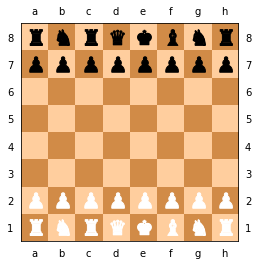

In [135]:
Chess().draw()

## b)

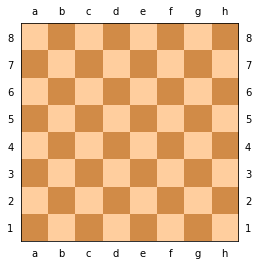

In [138]:
Chess(broad=np.zeros((8,8))).draw()

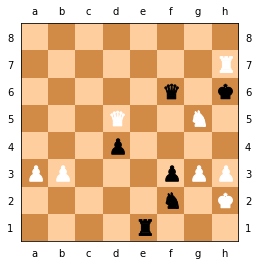

In [136]:
DEEPBLUE = np.array([[0, 0, 0,  0,  0,  0, 0,  0],
                     [0, 0, 0,  0,  0,  0, 0,  4],
                     [0, 0, 0,  0,  0, -5, 0, -6],
                     [0, 0, 0,  5,  0,  0, 2,  0],
                     [0, 0, 0, -1,  0,  0, 0,  0],
                     [1, 1, 0,  0,  0, -1, 1,  1],
                     [0, 0, 0,  0,  0, -2, 0,  6],
                     [0, 0, 0,  0, -4,  0, 0,  0]])

Chess(broad=DEEPBLUE).draw()

# 2. Supermarket

See code in [Q2.py](Q2.py)

Just run the file here and show output in the notebook.

2-a-both Alice and Bob walk: 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


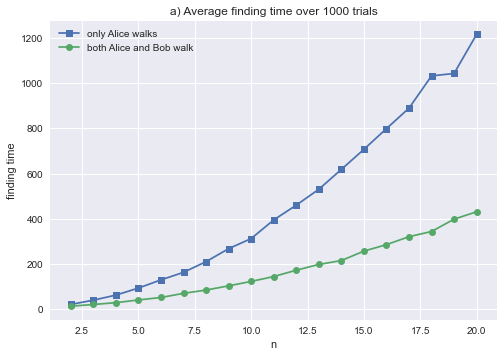

2-b-both Alice and Bob walk: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


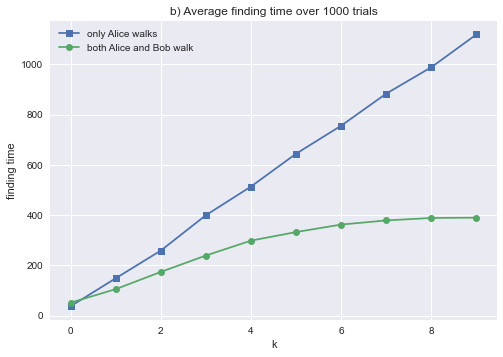

2-c-a-both Alice and Bob walk: 100%|██████████| 19/19 [00:31<00:00,  1.65s/it]


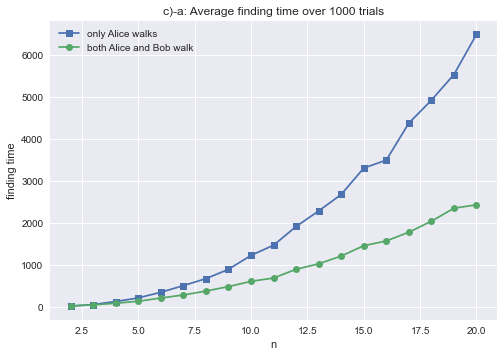

2-c-b-both Alice and Bob walk: 100%|██████████| 10/10 [00:37<00:00,  3.80s/it]


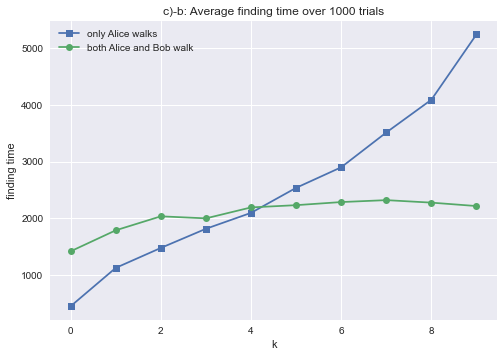

In [8]:
%run Q2.py

# 3. Artificial landscape

In [4]:
from matplotlib.cm import terrain
from matplotlib.colors import ListedColormap as LC
terrain_above_sea = LC(terrain(np.linspace(.15, 1, 256)))

def generate_landscape():
    """ Generate the altitudes of a random but smooth landscape.
        You do not need to understand how they are generated.
    
    Returns
    -------
    z: ndarray of float
        A 101*101 array of altitude.
        The sea level has an altitude of 0.
        
        Using the Cartesian coordinates (x, y),
        the element z[i, j] is the altitude at point (x=j/100, y=i/100).
        
        Note that x is proportional to j, whereas y is proportional to i.
        For example,
            * z[12, 34] is the altitude at point (x=.34, y=.12)
            * z[56, :] are the altitudes along y=.56
            * z[:, 78] are the altitudes along x=.78      
    """
    n, N = 20, 101
    x = y = np.arange(0, n, 1)
    xx, yy = np.meshgrid(x, y)
    zz = np.zeros((n, n))
    zz[:, 0], zz[0, :] = np.random.randn(2, n)
    for i in range(1, n):
        for j in range(1, n):
            zz[i, j] = ( zz[i-1, j]+zz[i, j-1] )/2 + np.random.randn()

    from scipy import interpolate
    from warnings import filterwarnings
    filterwarnings('ignore')
    x, y = np.linspace(0, n-1, N), np.linspace(0, n-1, N)
    return interpolate.bisplev(
        x, y, interpolate.bisplrep(
            xx.flatten(), yy.flatten(), zz.flatten(), s=1))

In [5]:
np.random.seed(114514)
landscape = np.array(generate_landscape())

## a)

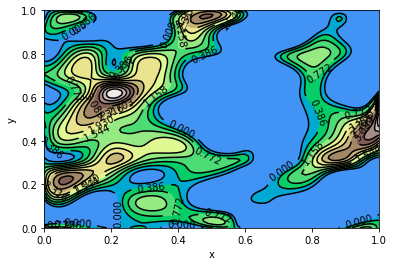

In [8]:
max_z=np.max(landscape)
min_z=np.min(landscape)
above_levels=np.linspace(0,max_z,13)

CSf=plt.contourf(landscape,above_levels,cmap=terrain_above_sea)
plt.contourf(landscape,[min_z,0],colors="#4293f6")
CS=plt.contour(landscape,above_levels,colors="black")
plt.clabel(CS,above_levels)
plt.xticks(np.linspace(0,100,6), np.round(np.linspace(0,1,6),2))
plt.yticks(np.linspace(0,100,6), np.round(np.linspace(0,1,6),2))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## b)

MovieWriter ffmpeg unavailable; using Pillow instead.


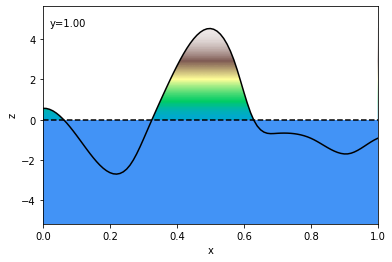

In [6]:
def draw_cross_section(landscape, ny):
    plt.cla()
    zs = landscape[:, ny]
    z_max = np.max(landscape)
    z_min = np.min(landscape)
    plt.imshow([[z_max, z_max], [0, 0]], cmap=terrain_above_sea, extent=[
               0, 100, 0, np.max(zs)], interpolation="bicubic", aspect="auto")
    xs = np.linspace(0, 100, len(zs))
    plt.plot(xs, zs, color="black")
    plt.fill_between(xs, zs, z_max, facecolor='white',
                     interpolate=True, alpha=1)
    plt.fill_between(xs, np.zeros_like(xs), z_min,
                     facecolor="#4293f6", interpolate=True, alpha=1)
    plt.plot(xs, np.zeros_like(xs), color="black", linestyle='dashed')
    plt.text(2, z_max, f"y={ny/100:.2f}")
    plt.xlim([0, 100])
    plt.xticks(np.linspace(0, 100, 6), np.round(np.linspace(0, 1, 6), 2))
    plt.xlabel("x")
    plt.ylabel("z")
    plt.ylim([z_min, z_max+1])


fig = plt.figure()
anim = FuncAnimation(fig, partial(draw_cross_section,
                                  landscape), frames=np.arange(0, 101))
anim.save("out/q3.gif")
anim

If you are in jupyter, you could have seen an animation player which can show the animation and a plot which is at $y=1$. If you can't see what I have seen, you may view "[q3.gif](out/q3.gif)" in "out" folder.

# 4. Goldbach's conjecture

## a)

In [34]:
class EulerSieve:
    def __init__(self, N):
        self.N = N
        self.is_primes = [False, False, *[True for i in range(2, N+1)]]
        self.primes = []
        self.num_phalf = 0
        for n in tqdm(range(2, N+1), desc="caching primes..."):
            if self.is_primes[n]:
                self.primes.append(n)
                if n <= N//2:
                    self.num_phalf += 1
            for p in self.primes:
                if (q := n*p) > N:
                    break
                self.is_primes[q] = False
                if n % p == 0:
                    break

    def isprime(self, num):
        return self.is_primes[num]

    def primes_half(self):
        """Get a list of prime where p <= N//2"""
        return self.primes[:self.num_phalf]
        

@return_in_list
def goldbach(N):
    es = EulerSieve(N)
    for p in es.primes_half():
        if es.isprime(N-p):
            yield p


In [33]:
goldbach(100)

caching primes...: 100%|██████████| 99/99 [00:00<?, ?it/s]


[3, 11, 17, 29, 41, 47]

## b)

In [41]:
@njit
def numba_goldbach(N, primes, num_phalf: int):
    nws = np.zeros(N+1)
    halfps = primes[:num_phalf]
    #p <= N//2
    for i, p in enumerate(halfps):
        # q >= p
        for q in primes[i:]:
            # the numba can't compile walrus operator, what's a pity
            s = p + q
            if s > N:
                break
            nws[s] += 1
    return nws


class NumGoldbach:
    CMAP = {
        3: "green",
        5: "red",
        7: "blue",
        15: "yellow",
        21: "cyan",
        35: "magenta",
        105: "grey"
    }

    def __init__(self, N, accelerate=False):
        self.N = N
        self.euler_sieve = EulerSieve(N)

        if not accelerate:

            self.nws = np.zeros(N+1)

            halfps = self.euler_sieve.primes_half()
            halflen = len(halfps)

            #p <= N//2
            for i, p in tqdm(enumerate(halfps), total=halflen, desc="calculating ngoldbach..."):
                # q >= p
                for q in self.euler_sieve.primes[i:]:
                    if (s := p+q) > N:
                        break
                    self.nws[s] += 1

        else:
            print("calculating ngoldbach...: ", end='', flush=True)
            start_time = time.perf_counter()
            primes = np.array(self.euler_sieve.primes)
            self.nws = numba_goldbach(N, primes, self.euler_sieve.num_phalf)
            end_time = time.perf_counter()
            print(
                f"\rcalculating ngoldbach...: (used time: {end_time-start_time}s)", flush=True)

    def assign_color(self, n):
        for div, c in reversed(self.CMAP.items()):
            if n % div == 0:
                return c
        if self.euler_sieve.isprime(n//2):
            return "orange"
        return "black"

    def draw(self, plt):
        ns = range(4, self.N+1, 2)
        cs = [self.assign_color(n)
              for n in tqdm(ns, desc="assigning color...")]

        print("drawing...")
        plt.scatter(ns, self.nws[4:self.N+1:2], c=cs, s=.1, alpha=.6)
        plt.xlabel("n")
        plt.ylabel("number of ways")


assigning color...: 100%|██████████| 499999/499999 [00:00<00:00, 959941.98it/s] 


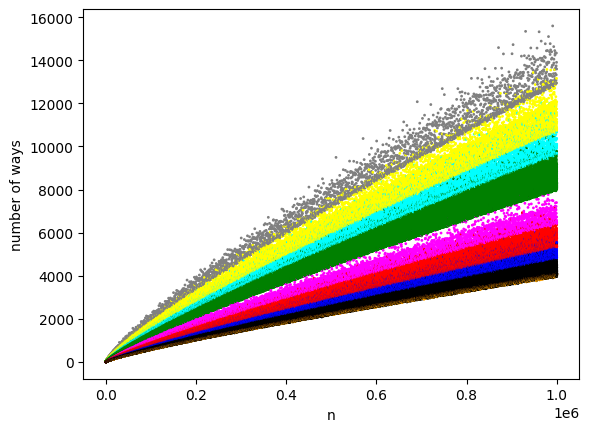

In [6]:
ngb = NumGoldbach(10**6)
ngb.draw(plt)
plt.savefig("out/q4-b.jpg")
plt.show()

caching primes...: 100%|██████████| 999999/999999 [00:00<00:00, 2025601.60it/s]

calculating ngoldbach...: 

calculating ngoldbach...: (used time: 7.948853460999999s)


assigning color...: 100%|██████████| 499999/499999 [00:00<00:00, 1071232.62it/s]


drawing...


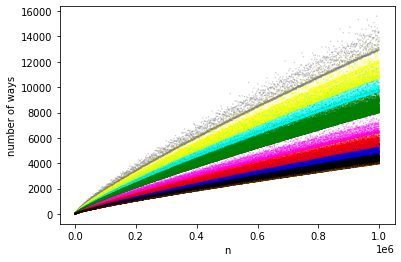

In [42]:
ngb = NumGoldbach(10**6,accelerate=True)
ngb.draw(plt)
plt.savefig("out/q4-b.jpg")
plt.show()

With using numba to accelerate, it only took about 7.5s to calculate goldbach within 1e6 and 15s to complete whole task comparing without using numba, the pure python version took about 7 minutes to complete task.

There are orange points under blacks indeed, although it seems unclear since black points block them. In order to view it clearly, please view the "[q4-b.jpg](out/q4-b.jpg)" in "out" folder.

# 5. Image processing

In [2]:
def greyit(img: np.ndarray):
    R, G, B = np.split(img, 3, axis=2)
    return .299*R+.587*G+.114*B


def convolute(C0: np.ndarray, F: np.ndarray):
    W0, H0, C = C0.shape
    K, _ = F.shape
    F = F[..., None]
    W1,H1=W0-K+1,H0-K+1
    C1 = np.zeros((W1, H1, C))
    for i, j in product(range(W1), range(H1)):
        C1[i, j, :] = np.sum(F*C0[i:i+K, j:j+K, :], axis=(0, 1))
    return C1


def blurit(img: np.ndarray, n=9):
    F = np.ones((n, n))/n**2
    return convolute(img, F)

def sharpit(img: np.ndarray, k=2):
    F = np.array([[0,0,0],[0,1,0],[0,0,0]])+k*np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
    C1 = convolute(img,F)
    C1[C1>255]=255
    C1[C1<0]=0
    return C1

def sobelit(img: np.ndarray):
    img=greyit(img)
    Sx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy=Sx.T
    Ex=convolute(img,Sx)
    Ey=convolute(img,Sy)
    return np.sqrt(Ex**2+Ey**2)

I just use the "[lenna.png](img/lenna.png)", since it's worthless to find another image to finish this work. If you want to use another image, you can change it by yourself.

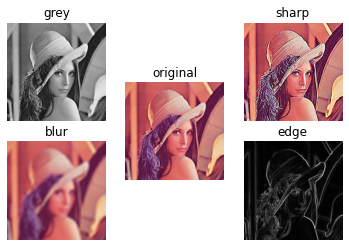

In [3]:
img = np.array(Image.open("img/lenna.png"))

args=(
    (132,lambda x:x,"original"),
    (231,greyit,"grey"),
    (234,blurit,"blur"),
    (233,sharpit,"sharp"),
    (236,sobelit,"edge")  
)

for pos,transform,title in args:
    ax=plt.subplot(pos)
    ax.imshow(transform(img)/255,cmap="gray")
    ax.set_title(title)
    ax.set_axis_off()
plt.show()

# 6. Minkowski's question mark function

In [73]:
@return_in_list
def cfracseq(x,k=20):
    for i in range(k+1):
        yield (a:=np.floor(x))
        if x == a:
            break
        x = 1/(x-a)

def mqmf(x,K=20):
    a = np.array(cfracseq(x,K))
    return a[0]+2*sum((-1)**(k+1)*.5**np.sum(a[1:k+1]) for k in range(1,K+1))


In [76]:
def test(f,*args,gt=None,ε=1e-6):
    assert abs(f(*args)-gt) < ε
    print(f"test {f.__name__}({','.join(map(str,args))})={gt} pass with tolerance ε={ε}")

test(mqmf,(3**.5-1)/2,gt=2/7)
test(mqmf,(3**.5)/2,gt=84/85)
test(mqmf,(5**.5-1)/2,gt=2/3)
test(mqmf,1/2**.5,gt=4/5)

test mqmf(0.3660254037844386)=0.2857142857142857 pass with tolerance ε=1e-06
test mqmf(0.8660254037844386)=0.9882352941176471 pass with tolerance ε=1e-06
test mqmf(0.6180339887498949)=0.6666666666666666 pass with tolerance ε=1e-06
test mqmf(0.7071067811865475)=0.8 pass with tolerance ε=1e-06


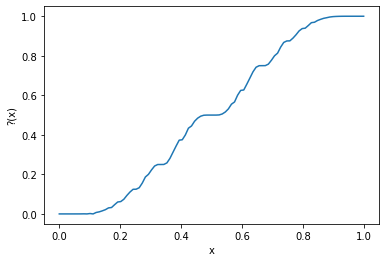

In [77]:
x=np.linspace(0,1,100)
y=tuple(map(mqmf,x))
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("?(x)")
plt.show()

# 7. Bifurcation diagram

MovieWriter ffmpeg unavailable; using Pillow instead.


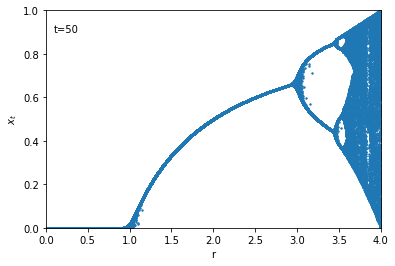

In [3]:
class Evolve:
    def __init__(self, N, interval=np.arange(1, 51)):
        self.r = np.random.uniform(0, 4, size=N)
        self.x = np.random.uniform(0, 1, size=N)
        self.xs = [self.x]
        for i in interval:
            self.x = self.r*self.x*(1-self.x)
            self.xs.append(self.x)

    def __call__(self, t):
        plt.cla()
        plt.scatter(self.r, self.xs[t], s=2)
        plt.text(0.1, 0.9, f"t={t}")
        plt.xlim([0, 4])
        plt.xlabel("r")
        plt.ylabel("$x_t$")
        plt.ylim([0, 1])


np.random.seed(114514)
evolve = Evolve(10**5, interval=np.arange(1, 51))
fig = plt.figure()
anim = FuncAnimation(fig, evolve, frames=np.arange(0, 51))
anim.save("out/q7.gif")
anim


If you are in jupyter, you could have seen an animation player which can show the animation and a plot which is the final state of evolution at $t=50$. If you can't see what I have seen, you may view "[q7.gif](out/q7.gif)" in "out" folder.